<h3>QTM 350 Final Project</h3>
<center>
<h1>RapidStudy</h1>
<h2>An AI-Powered Note Summarizer and Study Tool</h2>
<p>Jerry Hong, Eric Juarez, Jin Lee, <br> Christopher Roebuck, Raz Wachtel</p>
</center>

## About Us

Our team consists of students from a wide range of disciplines, including Biology, Computer Science, Economics, and Neuroscience. As Emory students, we all understand how difficult and time consuming it can be to study for finals, so we decided to tackle that problem head on with the tools we've been learning in QTM 350. By combining AWS Textract with ChatGPT, we would like to create a website that can turn our messy notes into organized and useful summaries.


The final result is RapidStudy ([link to repo](https://github.com/ejuar/rapid-study-web)), a platform that transforms your documents into intelligent study aids and saves you time. This blog post will detail the process of building an AI application with an AWS-driven workflow.

## AWS Architecture

<img src="https://my-bucket-roebuck.s3.amazonaws.com/architecture_diagram.png" width=700 height=500>

First, we will use AWS Amplify to build and deploy a user interface for RapidStudy. Then, we will develop a Lambda function to pass the picture inputs to Textract and the summary outputs back to the user. Textract will read the uploaded notes. Finally, we will give ChatGPT the raw text to create a polished summary, ready to be studied.

### AWS Textract

**From the rubric:** Walk us through how to use it and evaluate its performance. What works as you expected, what was unexpected

To start, we initialize an S3 bucket where it stores the document the user inputs. Because we're focusing on the inputted file, we will have Textract select the most recent file added to our document. From there, it will retrieve the key of that file.

In [ ]:
# retrieve the most recent file in the bucket

def top_file(bucket_name, file_extension = ['pdf', 'jpg', 'jpeg', 'png']):

    s3 = boto3.client('s3')
    response = s3.list_objects_v2(Bucket=bucket_name)

    # Check if the bucket is not empty
    if 'Contents' in response and response['Contents']:

        # Filter files by the specified extension and sort by last modified timestamp
        filtered_files = [obj for obj in response['Contents'] if any(obj['Key'].lower().endswith(ext) for ext in file_extension)]

        if filtered_files:
            most_recent_file = max(filtered_files, key=lambda x: x['LastModified'].timestamp())
            return most_recent_file['Key']

    return None

Now it has the key of the file, Textract will read that file. To start, we will check the file extension of the input file. Textract can read files of various types mainly PDF and image files like PNG/JPEG. Textract uses Optical Character Recognition or OCR where it detects any text that are displayed within the file. The premise of this is that Textract has different methods depending on the file type. For files that are multiple pages, we would call the `start_document_text_detection` method to read it. This is an asynchronous operation. For single-page file types and exclusively image files we would use `detect_document_text`. This is a synchronous operation. Because most inputs would be of multiple pages, we will exclusively use the `start_document_text_detection` method. It can accept both PDF and image file types.

In [ ]:
def start_text(bucket_name, document_key):
    textract = boto3.client('textract')

    # Check the file extension to determine the appropriate method
    file_extension = document_key.split('.')[-1].lower()

    if file_extension in ['pdf', 'jpg', 'jpeg', 'png']:
        response = textract.start_document_text_detection(
            DocumentLocation={
                'S3Object': {
                    'Bucket': bucket_name,
                    'Name': document_key
                }
            }
        )

    else:
        raise ValueError(f"Unsupported file type: {file_extension}")

    # Get the JobId for checking the analysis status
    job_id = response['JobId']
    return job_id

def get_text(job_id):
    textract = boto3.client('textract')
    response = None
    while response is None or response['JobStatus'] == 'IN_PROGRESS':
        response = textract.get_document_text_detection(JobId=job_id)

    return response


The outputted response is in a JSON format, but we need an easier data type to feed this output into ChatGPT. To address this, we initialize the output text as a string and then concatenate it for each line in Textract's response. This will faciliate the pipeline into ChatGPT for the next step.

In [ ]:
def extract_text(response):
    # Extract the detected text from the response
    detected_text = ""
    for page_result in response['Blocks']:
        if page_result['BlockType'] == 'LINE':
            detected_text += page_result['Text'] + "\n"

    return detected_text

### ChatGPT


With the output string from Textract, we can now feed this information to ChatGPT. To start, we need to call the key to communicate with OpenAi's ChatGPT API. In order to prevent any leak of the key, we store it in a text file within another S3 bucket. We created a method to retrieve the key from that text file. Now that we have the key, we can now talk with ChatGPT. Our prompt is to simply create a summary based on the extracted text of the user's notes. We pass this prompt into ChatGPT and it creates its output. Because we want an output file, we have it encode into a text file and upload it into an S3 bucket. We know the job is completed once it informs that the study guide is located in our summary bucket with the output filename. We simply concatenate 'summary' into the input filename for clarity.

In [ ]:
# pass the textract string to GPT

def api_key_s3(bucket, key_file):
    s3 = boto3.client('s3')
    obj = s3.get_object(Bucket=bucket, Key=key_file)
    return obj['Body'].read().decode('utf-8').strip()

def chatgpt_to_s3(api_key_bucket, api_key_file, extracted_text, Output_Bucket, file):
    s3 = boto3.client('s3')
    api_key = api_key_s3(api_key_bucket, api_key_file)
    openai.api_key = api_key

    prompt = f"Summarize these notes in a Study Guide:\n{extracted_text}."

    response = openai.ChatCompletion.create(
                model="gpt-3.5-turbo",
                messages=[{'role': 'user', 'content': prompt}]
            )
    output = response['choices'][0]['message']['content'].strip()

    output_filename = file.replace('.', '_') + '_summary.txt'
    output_bytes = io.BytesIO(output.encode())

    s3.upload_fileobj(output_bytes, Output_Bucket, output_filename)

    print(f"The Study Guide is Located in {Output_Bucket}/{output_filename}")

## Demo with Test Notes

Below is a demonstration of inputting raw notes about Tuberous Sclerosis Complex generating the study guide from ChatGPT. From the output, we see that the most recent file in our input bucket is those notes with the jobID specifying what file Textract is scanning. Finally, after the extracted text is passed to ChatGPT, it successfully created a study guide and stored in the approprate S3 bucket. The algorithm also was able to read an image file of handwritten notes and create a study guide from that.

In [ ]:
# initialize main function

api_key_bucket = 'gpt-api-bucket'
api_key_file = 'GPTKey2.txt'
Output_Bucket = 'gpt-summaries'


if __name__ == "__main__":
    bucket_name = 'textract-assets'

    # Get the most recent file from the bucket
    file = top_file(bucket_name)

    if most_recent_file:
        print(f"Most recent file in the bucket: {file}")

        job_id = start_text(bucket_name, file)
        print(f"Text detection job submitted. JobId: {job_id}")

        # Retrieve the results
        response = get_text(job_id)

        # Extract text from the document
        detected_text = extract_text(response)

        # pass to GPT
        chatgpt_to_s3(api_key_bucket, api_key_file, detected_text, Output_Bucket, file)

    else:
        print("The S3 bucket is empty.")




Most recent file in the bucket: Tuberous Sclerosis Complex Notes.pdf
Text detection job submitted. JobId: 7d36a8ad50cbaf27e79bd4677ff96ab0bf474c17639b0462d74cec9064f56587
The Study Guide is Located in gpt-summaries/Tuberous Sclerosis Complex Notes_pdf_summary.txt


### Challenges throughout the Project

While our concept is an interesting take of leveraging ML and AI capabilities, there were challenges implementing them and able to work in tandem. In addition, we encountered issues integrating our solution to the frontend of our website where the user can upload their file. The main obstacle for our Textract to GPT implementation is being able to pipeline between the two APIs. This was remedied by keeping track of how to access the APIs as well as providing the appropriate data type to feed into ChatGPT. In addition, the Textract API can only be accessed through SageMaker, so basically only one of the group members is able to test it out and see how to implement into our project. Within Textract, there issues as far as what file types the appropriate method can accept depending on whether it is a synchronous or asynchronous operation, while initially we used `detect_document_text` method, it was only limited to single page image files. That is why we went with the other method `start_document_text_detection` but this operation required different parameters as well as assigning a job_id, something the first method did not include. Finally, there were challenges regarding retrieving and storing files in S3 buckets and since we had three buckets used for this solution, we had to keep track of them depending on its purpose.

As far as our website implementation, the main issue is streamlining all of the API gateways and pipelines behind AWS. We at first encountered an issue where the runtime for the API gateway was limited to just 30 seconds, which could prevent larger files to be able to run in our website. When trying to integrate with our Textract/GPT solution, we need to use SageMaker Processing Jobs, since it can only run through SageMaker. This led to us possibly using the Elastic Container Registry to integrate our AWS services. However, our student accounts did not have access to this, so our last resort is to create an EC2 instance with networking endpoints, but time constraints led to offload this project. Nonetheless, our primary goal is to integrate Textract with ChatGPT, and we were able to develop a solution to our objective.

## Evaluation Analysis

To evaluate RapidFlow, we created six metrics to rate its performance and also performed a double blind Google Survey comparing RapidFlow's output to the original data. Our code behind these figures are in a separate Notebook for reference.

### Metrics

The word count difference between RapidFlow and the original data was evaluated to see if RapidFlow would shave some time from studying. It was able to decrease word count for half the notes.

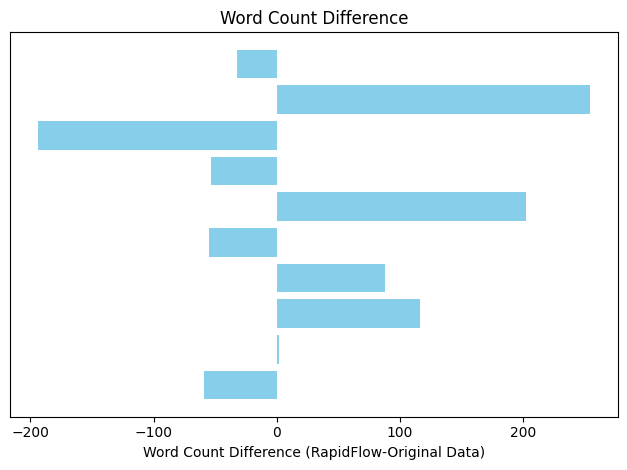

We also rated RapidFlow's notes on a scale of 1 to 10 on five different aspects. RapidFlow was good at making the content more concise, but not by much as it scored around 5 on average for all aspects. Notably, RapidFlow had the hardest time handling technical words in specialized fields such as neuroscience.

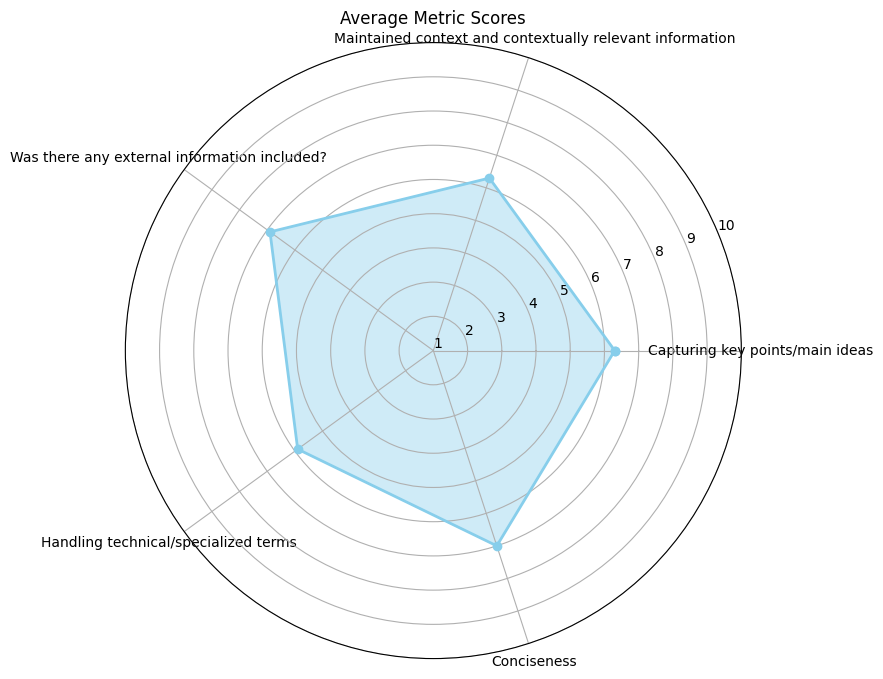

### Survey

The double blind survey contained both the original and RapidFlow's work and asked to evaluate both on a scale of 1 to 5 on three different aspects. The average score differences are shown below. While RapidFlow had better overall flow in readability, it did poorly on all three aspects in comparison to the original student notes.

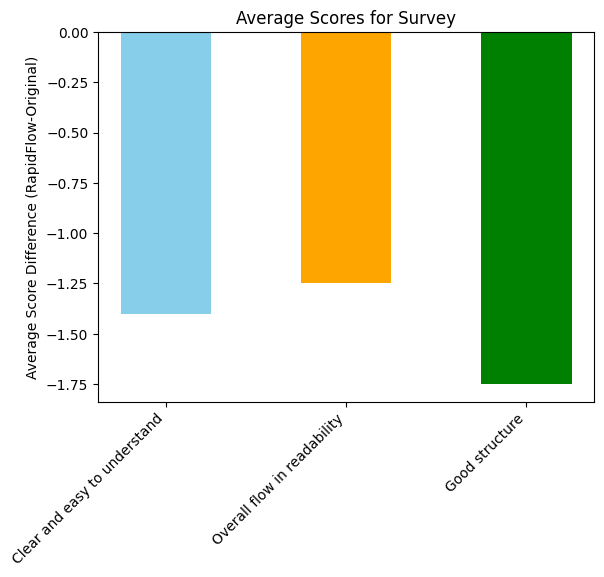

The survey also asked which set of notes were preferred, and everyone preferred the original notes compared to the current RapidFlow's notes. This can primarily be attribute to the structure of the notes where it is too clustered compared to nested notes of the original version. It seems well-structured notes can heavily affect the readability and therefore, understanding of the notes.

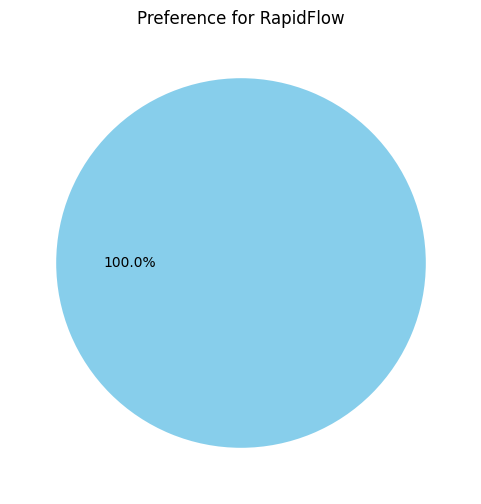

## Troubleshooting
While RapidFlow was able to decrease word count of notes, it will require updates to truly help students with studying for finals. The main aspect to address is to improve the organization and readability of the notes. In addition, we would refine the prompts to ensure all the main points of the notes are included in the study guide, something RapidFlow tended to overlook.